In the Data folder file I showed that t>20 basically corresponds to noise. Here I want to check if the network performance improves if I throw out this noise.

In [13]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

trancuate_t = 96 # set this parameter to control at which time step you stop using the signal
grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

In [24]:
Undersampled_Data.shape[0]

22

In [23]:
Ground_Truth = np.transpose(Ground_Truth, (0, 2, 4, 3, 1, 5))

Ground_Truth.shape

(22, 21, 8, 96, 22, 6)

Set Parameters

In [14]:
batch_size=64
num_convs = 10
Non_Residual = False # note that some of the networks had been trained as non-residual)
Single_Combination = False # Check if you want to take the model where k-space data was combined or not
Low_Rank_Input = True ## apply low rank to the input as well if True

#### Model import correct model
from Naive_CNN_3D import * #from Naive_CNN_3D_Residual_No_Batch_Norm import *

AF = 3 #                # defined so far for noisy:3, 5, 10, 20, 40

#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_Non_Residual/Layer/model.pth"  # Replace with your file path
#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_possoin_r0/5Layer/model.pth"
#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_Alternating/5Layer/model.pth"
#saved_model_path = "../saved_models/Naive_CNN_3D_Non_Residual_AF_5_possoin_r0/5Layer/model.pth"
if Single_Combination:
    saved_model_path = f"../saved_models/Naive_CNN_3D_AF_{AF}_possoin_r0_Full2Low_SC/{num_convs}Layer/model.pth"
    Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_possoin_3D_fixed_r0_AF_{AF}_Single_Combination.npy')

else:    
    saved_model_path = f"../saved_models/Naive_CNN_3D_AF_{AF}_possoin_r0_Full2Low_96/{num_convs}Layer/model.pth"
    Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_possoin_3D_fixed_r0_AF_{AF}.npy')
#### Load data ####
Ground_Truth = np.load('../data/LR_8_masked_P03-P08_self.npy')



#### additionally make LowRank 8 transformation on input of network, this improves the error significantly!
if Low_Rank_Input:
    Undersampled_Data[...,0] = low_rank(Undersampled_Data[...,0], 8)
    Undersampled_Data[...,1] = low_rank(Undersampled_Data[...,1], 8)
    Undersampled_Data[...,2] = low_rank(Undersampled_Data[...,2], 8)
    Undersampled_Data[...,3] = low_rank(Undersampled_Data[...,3], 8)
    Undersampled_Data[...,4] = low_rank(Undersampled_Data[...,4], 8)
    Undersampled_Data[...,5] = low_rank(Undersampled_Data[...,5], 8)

In [3]:
Ground_Truth[:,:,:,:,:,:5].shape

(22, 22, 21, 96, 8, 5)

In [4]:
#### Train_Test_Split ####
ground_truth_train, ground_truth_test = Ground_Truth[:,:,:,:,:,:5], Ground_Truth[:,:,:,:,:,5]  # Method: Leave last MRSI measurement as test set

#### Assign undersampled network input ####
NN_input_train, NN_input_test = Undersampled_Data[:,:,:,:trancuate_t,:,:5], Undersampled_Data[:,:,:,:trancuate_t,:,5]

#### Fourier transform ####
training_undersampled, test_undersampled = fourier_transform(NN_input_train), fourier_transform(NN_input_test)

#### Collapse ununsed dimensions ####
ground_truth_train, ground_truth_test = ground_truth_train.reshape(22, 22, 21, -1), ground_truth_test.reshape(22, 22, 21, -1)
NN_input_train, NN_input_test = NN_input_train.reshape(22, 22, 21, -1), NN_input_test.reshape(22, 22, 21, -1)
training_undersampled, test_undersampled = training_undersampled.reshape(22, 22, 21, -1), test_undersampled.reshape(22, 22, 21, -1)

#### Normalize data #####
normalized_input_train, normalized_ground_truth_train, norm_values_train = normalize_data_per_image_new(NN_input_train, ground_truth_train)
normalized_input_test, normalized_ground_truth_test, norm_values_test = normalize_data_per_image_new(NN_input_test, ground_truth_test)
_, normalized_train_FT, _ = normalize_data_per_image_new(NN_input_train, training_undersampled)
_, normalized_test_FT, _ = normalize_data_per_image_new(NN_input_test, test_undersampled)

#### reshape for pytorch ####
train_data, train_labels  = reshape_for_pytorch(normalized_input_train, grouped_time_steps), reshape_for_pytorch(normalized_ground_truth_train, grouped_time_steps)
test_data, test_labels = reshape_for_pytorch(normalized_input_test, grouped_time_steps), reshape_for_pytorch(normalized_ground_truth_test, grouped_time_steps)

# Prepare k-space data (reshape undersampled k-space as well)
train_k_space = reshape_for_pytorch(normalized_train_FT, grouped_time_steps)
test_k_space = reshape_for_pytorch(normalized_test_FT, grouped_time_steps)

In [5]:
#### Set parameters ####

# Create TensorDataset instances
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Number of convolutional layers
model = Naive_CNN_3D(grouped_time_steps=grouped_time_steps, num_convs=num_convs).to(device)

#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_Non_Residual/5Layer/model.pth"  # Replace with your file path

# 2. Load the model's state_dict (weights) from the saved file

checkpoint = torch.load(saved_model_path, map_location=device)
# Extract the model state_dict
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

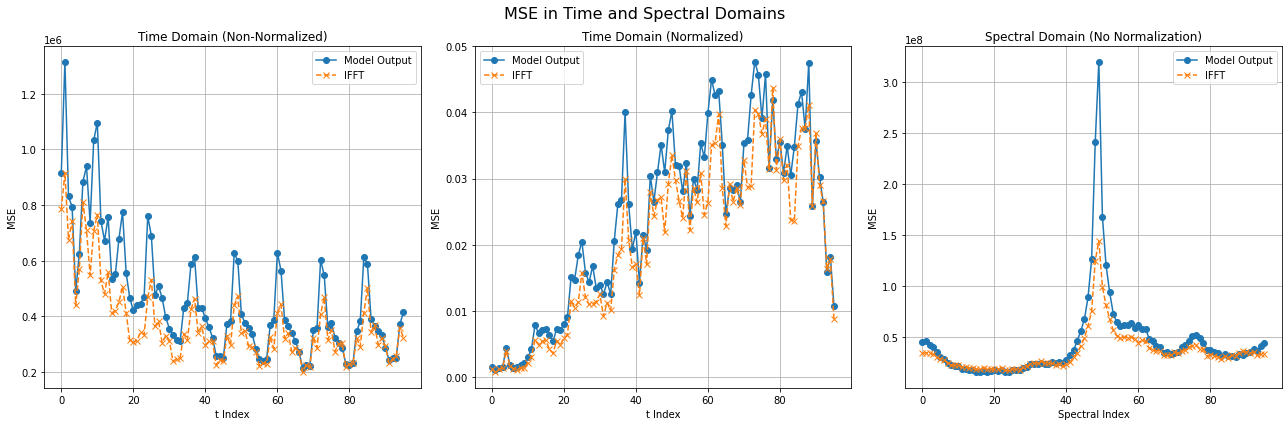

==== Model Output vs Ground Truth ====
Total MSE in image domain: 232793.5625
Normalized Total MSE in image domain: 0.011787690946996438
Total MSE in spectral domain: 22348182.74766327

==== Model Input vs Ground Truth ====
Total MSE in image domain: 187399.4375
Normalized Total MSE in image domain: 0.010121026443295237
Total MSE in spectral domain: 17990345.513992805


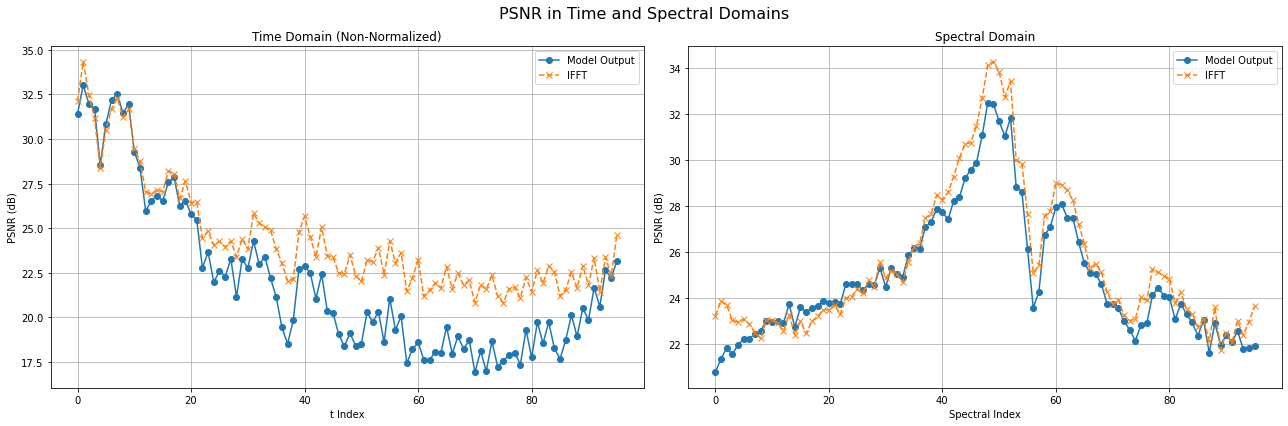

==== Model Output vs. Ground Truth ====
Average PSNR in image domain:    22.04548454284668
Average PSNR in frequency domain: 24.89366582750716

==== Model Input vs. Ground Truth ====
Average PSNR in image domain:    24.369918823242188
Average PSNR in frequency domain: 25.470788989344555


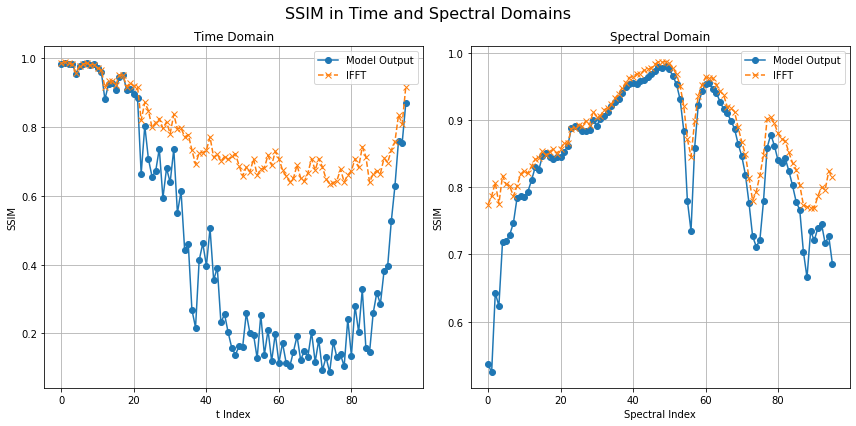

==== Model Output vs. Ground Truth ====
Average SSIM in image domain:    0.4699330763942109
Average SSIM in frequency domain: 0.8439730394245784

==== Model Input vs. Ground Truth ====
Average SSIM in image domain:    0.7732604172380642
Average SSIM in frequency domain: 0.880236517745374


In [12]:
Model_Outputs_Test_Set, ground_truth = Process_Model_Output(test_loader, model, device, trancuate_t, 8, grouped_time_steps, norm_values_test)

mask = np.load('../data/masks.npy')
mask_5 = mask[:,:,:,5]
mask_5D = mask_5[:,:,:, np.newaxis, np.newaxis]

Model_Outputs_Test_Set = Model_Outputs_Test_Set*mask_5D


# if Non_Residual:
#     Model_Outputs_Test_Set = Model_Outputs_Test_Set - model_input

# Noise = ground_truth[:, :, :, 95, :]   # e.g. shape: (X, Y, Z, coil_dim)

# # Compute 2-norm per coil
# two_norm_per_big_T = np.sqrt(np.sum(np.abs(Noise)**2, axis=(0, 1, 2)))
# # shape of two_norm_per_coil is now (coil_dim,)

# # Take the mean across coils
# two_norm_noise_average = np.mean(two_norm_per_big_T)

# Undersampling_Error = ground_truth[:, :, :, 0, :] - model_input[:, :, :, 0, :]  # e.g. shape: (X, Y, Z, coil_dim)

# # Compute 2-norm per coil
# two_norm_per_big_T = np.sqrt(np.sum(np.abs(Undersampling_Error)**2, axis=(0, 1, 2)))
# # shape of two_norm_per_coil is now (coil_dim,)

# # Take the mean across coils
# two_norm_US_average = np.mean(two_norm_per_big_T)

# Quotient = two_norm_US_average / two_norm_noise_average

# print("Undersampling error / noise error:", Quotient)

norm_values_test = norm_values_test.reshape(96,8)
model_input = Undersampled_Data[:,:,:,:trancuate_t,:,5]

### to be fair, I compute a LR approximation, as a trivial baseline comparison + apply the mask
model_input = low_rank(model_input, 8)*mask_5D

plot_general_statistics(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test)
plot_general_statistics_PSNR(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test)
plot_general_statistics_SSIM(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test,  label = "Model Output")

In [7]:
# tf = 23 #15 = Water, 17 Glucose, 23 Glx
# T = 7

# model_input = Undersampled_Data[:,:,:,:trancuate_t,:,5]

# comparison_Plot_3D_vs_Ifft(Model_Outputs_Test_Set, ground_truth, model_input, tf, T, domain="spectral")

In [8]:
Model_Outputs_Test_Set, ground_truth = Process_Model_Output(test_loader, model, device, trancuate_t, 8, grouped_time_steps, norm_values_test)

mask = np.load('../data/masks.npy')
mask_5 = mask[:,:,:,5]
mask_5D = mask_5[:,:,:, np.newaxis, np.newaxis]

Model_Outputs_Test_Set = Model_Outputs_Test_Set*mask_5D

norm_values_test = norm_values_test.reshape(96,8)
model_input = Undersampled_Data[:,:,:,:trancuate_t,:,5]

### to be fair, I compute a LR approximation, as a trivial baseline comparison + apply the mask
model_input = low_rank(model_input, 8)*mask_5D

ground_truth_spectral = np.fft.fftshift(np.fft.fft(ground_truth, axis=-2), axes=-2)
model_pred_spectral = np.fft.fftshift(np.fft.fft(Model_Outputs_Test_Set, axis=-2), axes=-2)
IFF_LR_8 = np.fft.fftshift(np.fft.fft(model_input, axis=-2), axes=-2)


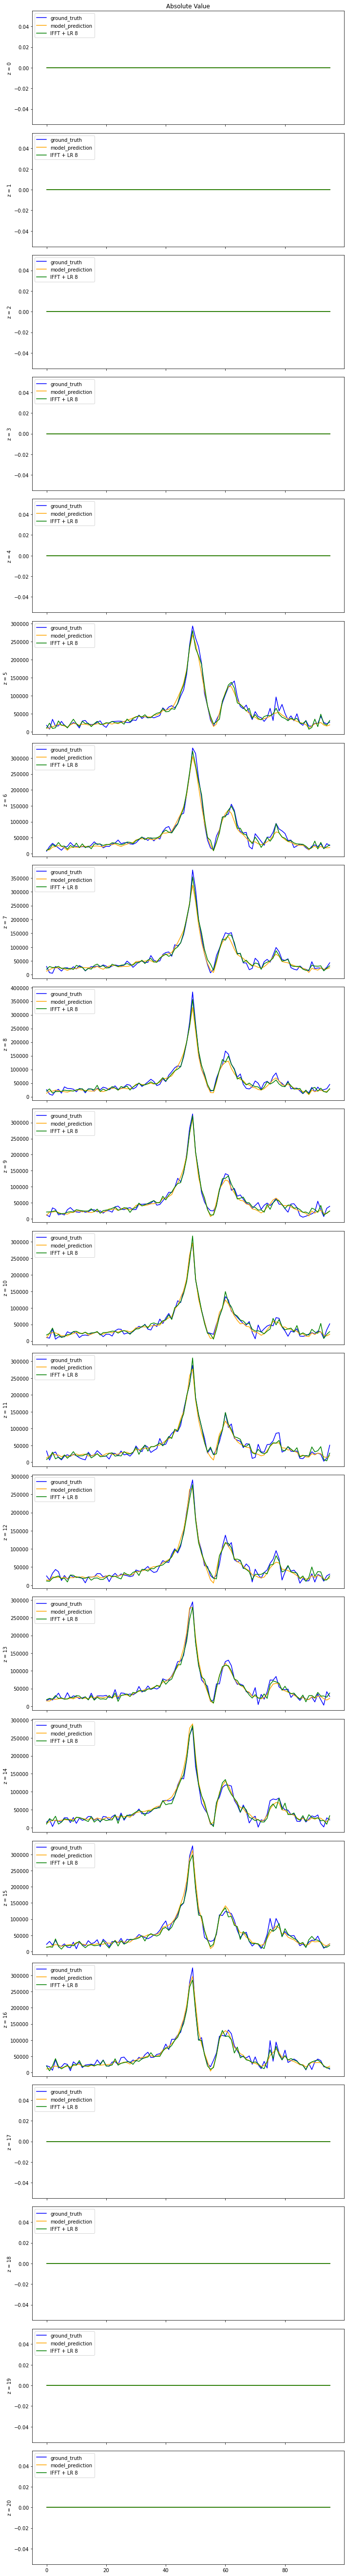

In [9]:
model_input = Undersampled_Data[:,:,:,:trancuate_t,:,5]
model_input = low_rank(model_input, 8)*mask_5D

IFF_LR_8 = np.fft.fftshift(np.fft.fft(model_input, axis=-2), axes=-2)
# Fixed indices for x, y, and T:
x_fixed = 10    # for example
y_fixed = 15    # for example
T_fixed = 7     # for example

num_z = 21  # Number of z slices (rows)

# Create a grid: 21 rows (each z-slice) and 3 columns (abs, real, imaginary)
fig, axes = plt.subplots(nrows=num_z, ncols=1, figsize=(10, num_z * 3.5), sharex=True)

for z in range(num_z):
    # Extract the spectral data at the fixed x, y, T for the current z-slice:
    gt_spec = ground_truth_spectral[x_fixed, y_fixed, z, :, T_fixed]
    mp_spec = model_pred_spectral[x_fixed, y_fixed, z, :, T_fixed]
    iff_spec = IFF_LR_8[x_fixed, y_fixed, z, :, T_fixed]
    
    # --- Column 1: Absolute value ---
    ax_abs = axes[z]
    ax_abs.plot(np.abs(gt_spec), label='ground_truth', color='blue')
    ax_abs.plot(np.abs(mp_spec), label='model_prediction', color='orange')
    ax_abs.plot(np.abs(iff_spec), label='IFFT + LR 8', color='green')
    ax_abs.set_ylabel(f'z = {z}')
    if z == 0:
        ax_abs.set_title('Absolute Value')
    ax_abs.legend(loc='upper left')
    
#     # --- Column 2: Real part ---
#     ax_real = axes[z, 1]
#     ax_real.plot(np.real(gt_spec), label='ground_truth', color='blue')
#     ax_real.plot(np.real(mp_spec), label='model_prediction', color='orange')
#     ax_real.plot(np.real(iff_spec), label='IFFT + LR 8', color='green')
#     if z == 0:
#         ax_real.set_title('Real Part')
#     ax_real.legend(loc='upper left')
    
#     # --- Column 3: Imaginary part ---
#     ax_imag = axes[z, 2]
#     ax_imag.plot(np.imag(gt_spec), label='ground_truth', color='blue')
#     ax_imag.plot(np.imag(mp_spec), label='model_prediction', color='orange')
#     ax_imag.plot(np.imag(iff_spec), label='IFFT + LR 8', color='green')
#     if z == 0:
#         ax_imag.set_title('Imaginary Part')
#     ax_imag.legend(loc='upper left')

# Set a common x-label (frequency index) for the bottom row subplots
# for ax in axes[-1, :]:
#     ax.set_xlabel('Frequency index (f)')

plt.tight_layout()
plt.show()

(22, 22, 21, 96, 8)


Text(0, 0.5, 'Amplitude')

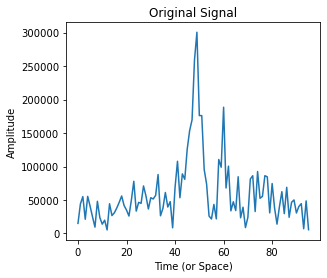

In [10]:
x, y, z, T = 10, 15, 10, 7

Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_possoin_3D_fixed_r0_AF_{AF}.npy')
model_input = Undersampled_Data[:,:,:,:trancuate_t,:,5]

print(model_input.shape)

H = np.abs(np.fft.fftshift(np.fft.fft(model_input, axis=-2), axes=-2))
H = H[x,y,z,:,T]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(H)
plt.title("Original Signal")
plt.xlabel("Time (or Space)")
plt.ylabel("Amplitude")